# MONODEPTH on OpenVINO IR Model

WORK IN PROGRESS NOTEBOOK NOT FOR PUBLIC RELEASE

This notebook demonstrates Monocular Depth Estimation with the MidasNet model in OpenVINO. https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/midasnet/midasnet.md

## Preparation 

### Install required Python\* packages

Install the required Python\* packages by executing `pip install -r requirements.txt` in a terminal, in the directory that contains this notebook. See the [README](https://github.com/helena-intel/openvino-notebooks/blob/develop/README.md) for more details and instructions for how to set up a virtual environment. 

You can also uncomment and run the cell below to install these requirements. Note that installation may take a while. There is no progress indicator.

In [1]:
# # OpenVINO
# !pip install --quiet --index-url https://test.pypi.org/simple --extra-index-url https://pypi.org/simple openvino-dev
# # Other packages
# !pip install --quiet matplotlib pytube Pillow

### Imports

In [2]:
import copy
import os
import time
import urllib
from base64 import b64encode
from pathlib import Path

import cv2
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from IPython.display import Image as DisplayImage
from openvino.inference_engine import IECore
from PIL import Image
from pytube import YouTube

### Settings

In [3]:
precision = "FP16"
device = "CPU"
MODEL_DIR = "models"
model_url = "https://officemacros.nl/midasnet.xml"  # TODO: move to an official download link

model_name = os.path.basename(model_url)
model_xml_path = Path(MODEL_DIR) / model_name

## Functions

In [4]:
def normalize_minmax(data):
    """Normalizes the values in `data` between 0 and 1"""
    return (data - data.min()) / (data.max() - data.min())

In [5]:
def download_ir_model(model_xml_url, directory):
    """
    Downloads IR model from `model_xml_url` and save it to `directory` with the same filename. The directory will be
    created if it does not exist.
    """
    os.makedirs(directory, exist_ok=True)
    model_name = os.path.basename(model_xml_url)
    model_xml_path = f"{directory}/{model_name}"
    if not os.path.exists(model_xml_path):
        urllib.request.urlretrieve(model_xml_url, model_xml_path)
        urllib.request.urlretrieve(model_xml_url[:-4] + ".bin", f"{model_xml_path[:-4]}.bin")
        print(f"Model {model_name} downloaded to {directory}")
    else:
        print(f"Model {model_name} already exists in {directory}")

In [6]:
def load_image(path: str):
    """
    Loads an image from `path` and returns it as BGR numpy array. `path` should point to an image file,
    either a local filename or an url.
    """
    if path.startswith("http"):
        # Set User-Agent to Mozilla because some websites block requests with User-Agent Python
        request = urllib.request.Request(path, headers={"User-Agent": "Mozilla/5.0"})
        response = urllib.request.urlopen(request)
        array = np.asarray(bytearray(response.read()), dtype="uint8")
        image = cv2.imdecode(array, -1)  # Loads the image as BGR
    else:
        image = cv2.imread(path)
    return image

In [7]:
def convert_result_to_image(result, colormap="viridis"):
    """
    Convert network result of floating point numbers to an RGB image with integer values from 0-255
    by applying a colormap.

    `result` is expected to be a single network result in 1,H,W shape
    `colormap` is a matplotlib colormap. See https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    cmap = matplotlib.cm.get_cmap(colormap)
    result = result.squeeze(0)
    result = normalize_minmax(result)
    result = cmap(result)[:, :, :3] * 255
    result = result.astype(np.uint8)
    return result

## Load model and get model information

Load the model in Inference Engine with `ie.read_network` and load it to the specified device with `ie.load_network`

In [8]:
download_ir_model(model_url, MODEL_DIR)

Model midasnet.xml already exists in models


In [9]:
ie = IECore()
net = ie.read_network(str(model_xml_path), str(model_xml_path.with_suffix(".bin")))
exec_net = ie.load_network(network=net, device_name="CPU")

input_key = list(exec_net.input_info)[0]
output_key = list(exec_net.outputs.keys())[0]

network_input_shape = exec_net.input_info[input_key].tensor_desc.dims
network_image_height, network_image_width = network_input_shape[2:]

## Monodepth on Image

### Load, resize and reshape input image

The input image is read with OpenCV, resized to network input size, and reshaped to (N,C,H,W) (H=height, W=width, C=number of channels, N=number of images). 

In [ ]:
# Download and load an image
# Image source (CC licence): https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=segmentation&r=false&c=%2Fm%2F02rgn06&id=470c2f96cb938855
IMAGE_URL = r"https://officemacros.nl/image.jpg"  # TODO: move to storage.openvinotoolkit.org

image = load_image(IMAGE_URL)
resized_image = cv2.resize(image, (network_image_height, network_image_width))  # resize to input shape for network
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)  # reshape image to network input shape NCHW

### Do inference on image

Do the inference, convert the result to an image, and resize it to the original image shape

In [11]:
result = exec_net.infer(inputs={input_key: input_image})[output_key]
# convert network result of disparity map to an image that shows distance as colors
result_image = convert_result_to_image(result)
# resize back to original image shape. cv2.resize expects shape in (width, height), [::-1] reverses the (height, width) shape to match this.
result_image = cv2.resize(result_image, image.shape[:2][::-1])

### Display monodepth image

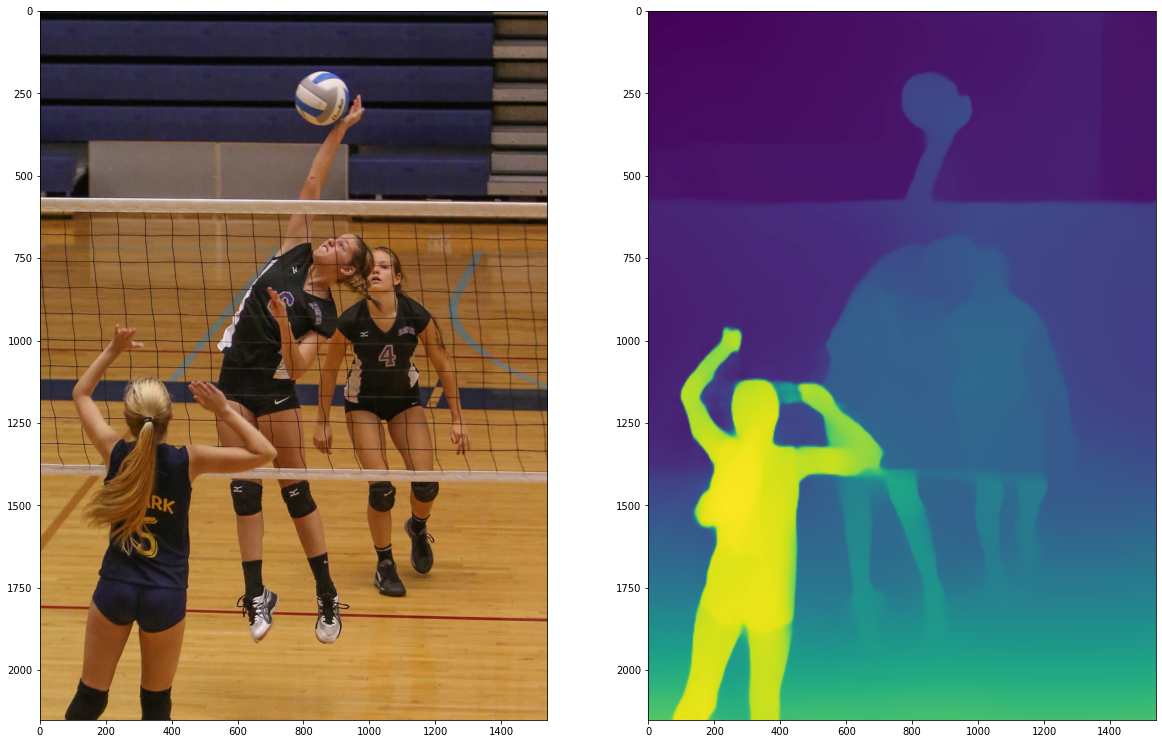

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(image[:, :, (2, 1, 0)])  # (2,1,0) converts the image from BGR to RGB
ax[1].imshow(result_image);